# Train Model

### Notes:

1. considering how much upsampling is going in in each channels for accounting for the perception of each frequency band... I could get away with downsampling the whole thing in the frequency direction by a factor of 4, 8 or even 16, reducing the sample rate post upsample.... this could worth for both the masking model and the diffusion model easily, reducing the image size from (1024, 175) to (128, 175)

2. I need to edit the levels of the training data so that anything where the signal is greater than 1 (due to high noise), should be normalised to 1

Next Steps:

2. Compare custom res-net model with attention as masking with deeplabv3_resnet50 altered. To complete the project, compare:
3. a) Custom simple, b) custom complex, c) deeplabv3_resnet50 d) lraspp_mobilenet_v3_large e) segformer
4. run test and get results
5. Write small extract on findings, and put into markdown on github.

In [1]:
import sys
import os

# Detect Google Colab
if "google.colab" in sys.modules:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Detect Google Colab
if "google.colab" in sys.modules:
    print("Running in Google Colab...")
    os.system("git clone https://github.com/CiaranMaloy/audioautoencoder")
    os.chdir("/content/audioautoencoder/")
    os.system("git pull")
    os.system("git checkout no-features-results")
    os.system("git pull origin no-features-results")
    #os.system("pip install --upgrade torchmetrics")
else:
    print("Running locally...")
    os.system("git pull origin no-features-results")
    #os.system("pip install --upgrade torchmetrics")


Running in Google Colab...


In [3]:
import sys
sys.path.append('/content/audioautoencoder')
sys.path.append('/content/audioautoencoder/audioautoencoder')

## Define Model

In [4]:
from audioautoencoder.models.UNetConv10mask import *

## Test Model

In [5]:
BATCH_SIZE = 1
TEST_MODEL = True

if TEST_MODEL:
  if __name__ == "__main__":
      x = torch.randn((BATCH_SIZE, 4, 1025 // 4, 175))
      model = UNetConv10(in_channels=4, out_channels=4)
      model.eval()
      output = model(x)

      print('output....')
      print(output.shape)

output....
torch.Size([1, 4, 256, 175])


In [6]:
!pip install torchinfo

In [7]:
from torchinfo import summary

# For example, if the input size is (batch_size=2, channels=9, height=256, width=256):
summary(model, input_size=(2, 4, 1025 // 4, 175))


Layer (type:depth-idx)                   Output Shape              Param #
UNetConv10                               [2, 4, 256, 175]          --
├─Sequential: 1-1                        [2, 64, 118, 88]          --
│    └─Conv2d: 2-1                       [2, 64, 125, 88]          7,744
│    └─BatchNorm2d: 2-2                  [2, 64, 125, 88]          128
│    └─LeakyReLU: 2-3                    [2, 64, 125, 88]          --
│    └─Conv2d: 2-4                       [2, 64, 118, 88]          122,944
│    └─BatchNorm2d: 2-5                  [2, 64, 118, 88]          128
│    └─LeakyReLU: 2-6                    [2, 64, 118, 88]          --
├─Sequential: 1-2                        [2, 128, 56, 41]          --
│    └─Conv2d: 2-7                       [2, 128, 58, 43]          204,928
│    └─BatchNorm2d: 2-8                  [2, 128, 58, 43]          256
│    └─LeakyReLU: 2-9                    [2, 128, 58, 43]          --
│    └─Conv2d: 2-10                      [2, 128, 56, 41]          40

## Define Params

In [8]:
from audioautoencoder.plotting import *
from audioautoencoder.datasets.utils import *
#from audioautoencoder.models.UNetConv10mask import *
# Instantiate the model, define loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetConv10(in_channels=4, out_channels=4).to(device)

print(device)

cpu


In [9]:
i = 0
train = True
LOAD_DATA = True
load_model = False

# --------------- Main Execution parameters ---------------
model_name = 'UNetConv10'
train_diffusion = False
SNRdB_load = [-10, 10]
SNRdBs = [[-10, 10]] # SNR random range
load_trigger = [load_model]
#load_file = 'Autoencodermodel_earlystopping.pth'
load_file = 'Autoencodermodel_checkpoint.pth'

folder = ['sep_features', 'all-noise_features', 'all-noise_features_2'][2] # sep

# parameters
learning_rates = [1e-3] # 1e-4 for re0training?, 1e-3 for training? # lowered learning rate for
                        # when the loss explodes after the learning rate increases, it means dont increase the learning rate too much
base_lr=1e-5
max_lr=learning_rates[i]
gamma=0.8

# data params
max_file_size_gb = 100
IMPORT_TRAIN_NOISY = train
batch_size = 256
num_workers = 12

# training params
load = load_trigger[i]
warm_start = True
epochs = 100
accumulation_steps = int((512*2)/batch_size)

SNRdB = SNRdBs[i]
learning_rate = learning_rates[i]
eta_min = 1e-6

print('lr:', learning_rate)
print('SNRdB:', SNRdB)

lr: 0.001
SNRdB: [-10, 10]


In [10]:
# --------------- In Loop Parameters --------------
output_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB[0]}-{SNRdB[1]}/'
load_path = f'/content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_{model_name}_{SNRdB_load[0]}-{SNRdB_load[1]}/{load_file}'

## Load Data

In [11]:
import os
import joblib  # or use pickle if you prefer

def save_scalers(scalers, save_path):
    """Save scalers to a file."""
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(scalers, save_path)

def load_scalers(save_path):
    """Load scalers from a file."""
    return joblib.load(save_path)

In [12]:
from audioautoencoder.datasets.utils import *
from audioautoencoder.data import *
from audioautoencoder.data_management import *
from audioautoencoder.generate_dataset import *

In [13]:
# Define the source and destination file paths
if LOAD_DATA:
  scaler_file = output_path + "scalers.pkl"  # Static filename since it's unique per run
  os.makedirs(os.path.dirname(scaler_file), exist_ok=True)
  source_folder = f"/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_{folder}/SNRdB_{SNRdB[0]}-{SNRdB[1]}/"
  source_path = source_folder + "train/"
  destination_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/"
  save_path = source_folder + "combined_000.h5"
  subset = False

  if IMPORT_TRAIN_NOISY:
    dataset_path = f"/content/SNRdB_{SNRdB[0]}-{SNRdB[1]}/train/combined_000.h5"
    if not os.path.exists(destination_path):
      #combine_h5_files_features(source_path, destination_path, max_file_size_gb=max_file_size_gb)
      combine_h5_files_spectrograms(source_path, destination_path, max_file_size_gb=max_file_size_gb)

    if os.path.exists(scaler_file):
        print("Loading existing scalers...")
        scalers = load_scalers(scaler_file)
    else:
        print("Training new scalers...")
        scalers = train_scalers_no_features(dataset_path, sample_size=8000)
        save_scalers(scalers, scaler_file)

    print(scalers)

    train_loader = ChannelDatasetLoader(
          dataset_path=dataset_path,
          scalers=scalers,
          output_time_length=175,
          channels=1,
          snr_db=SNRdB,
          subset=subset,
          batch_size=batch_size,
          num_workers=num_workers
      )

    print(f"Training set size: {len(train_loader.train_dataset)}")
    print(f"Validation set size: {len(train_loader.val_dataset)}")

Created new file: /content/SNRdB_-10-10/train/combined_000.h5


Processing:   1%|          | 5/596 [00:55<1:49:39, 11.13s/it, samples=1000, size=1.336 GB]


 Attempt 1 failed: Timeout after 20 seconds. Retrying in 3 seconds.

 Attempt 2 failed: Timeout after 40 seconds. Retrying in 3 seconds.

 Attempt 3 failed: Timeout after 60 seconds. Retrying in 3 seconds.

 Attempt 4 failed: Timeout after 80 seconds. Retrying in 3 seconds.


Processing:   1%|          | 6/596 [04:57<14:41:13, 89.62s/it, samples=1000, size=1.336 GB]

File:/content/drive/MyDrive/Datasets/Music-Noise/SNRdB_all-noise_features_2/SNRdB_-10-10/train/train-SNRdB_-10-10_20250327_190812.h5 skipped...


Processing:   3%|▎         | 16/596 [07:19<4:25:37, 27.48s/it, samples=3728, size=4.982 GB]


Finished combining files into 1 output files in /content/SNRdB_-10-10/train/
Loading existing scalers...
{'input_features_spectrogram': StandardScaler(), 'target_features_spectrogram': StandardScaler()}
Training set size: 2982
Validation set size: 746
Training set size: 2982
Validation set size: 746


## Inspect Data

In [14]:
if LOAD_DATA:
  _, output, medatata = train_loader.train_dataset[200]
  #input, output = train_dataset[0]
  #print(metadata['snr_db'])
  #print(input.shape)
  print(output.shape)

torch.Size([4, 256, 175])


7.3148722648620605
(4, 256, 175)
(256, 175)
Min, Max:  0.0 1.206313
(256, 175)
Min, Max:  0.0 1.0863258
(256, 175)
Min, Max:  0.0 1.1405725
(256, 175)
Min, Max:  0.0 1.0140934
Min, Max:  0.0 0.89359325
Min, Max:  0.0 1.0824852
Min, Max:  0.0 1.1345958
Min, Max:  0.0 1.0086906


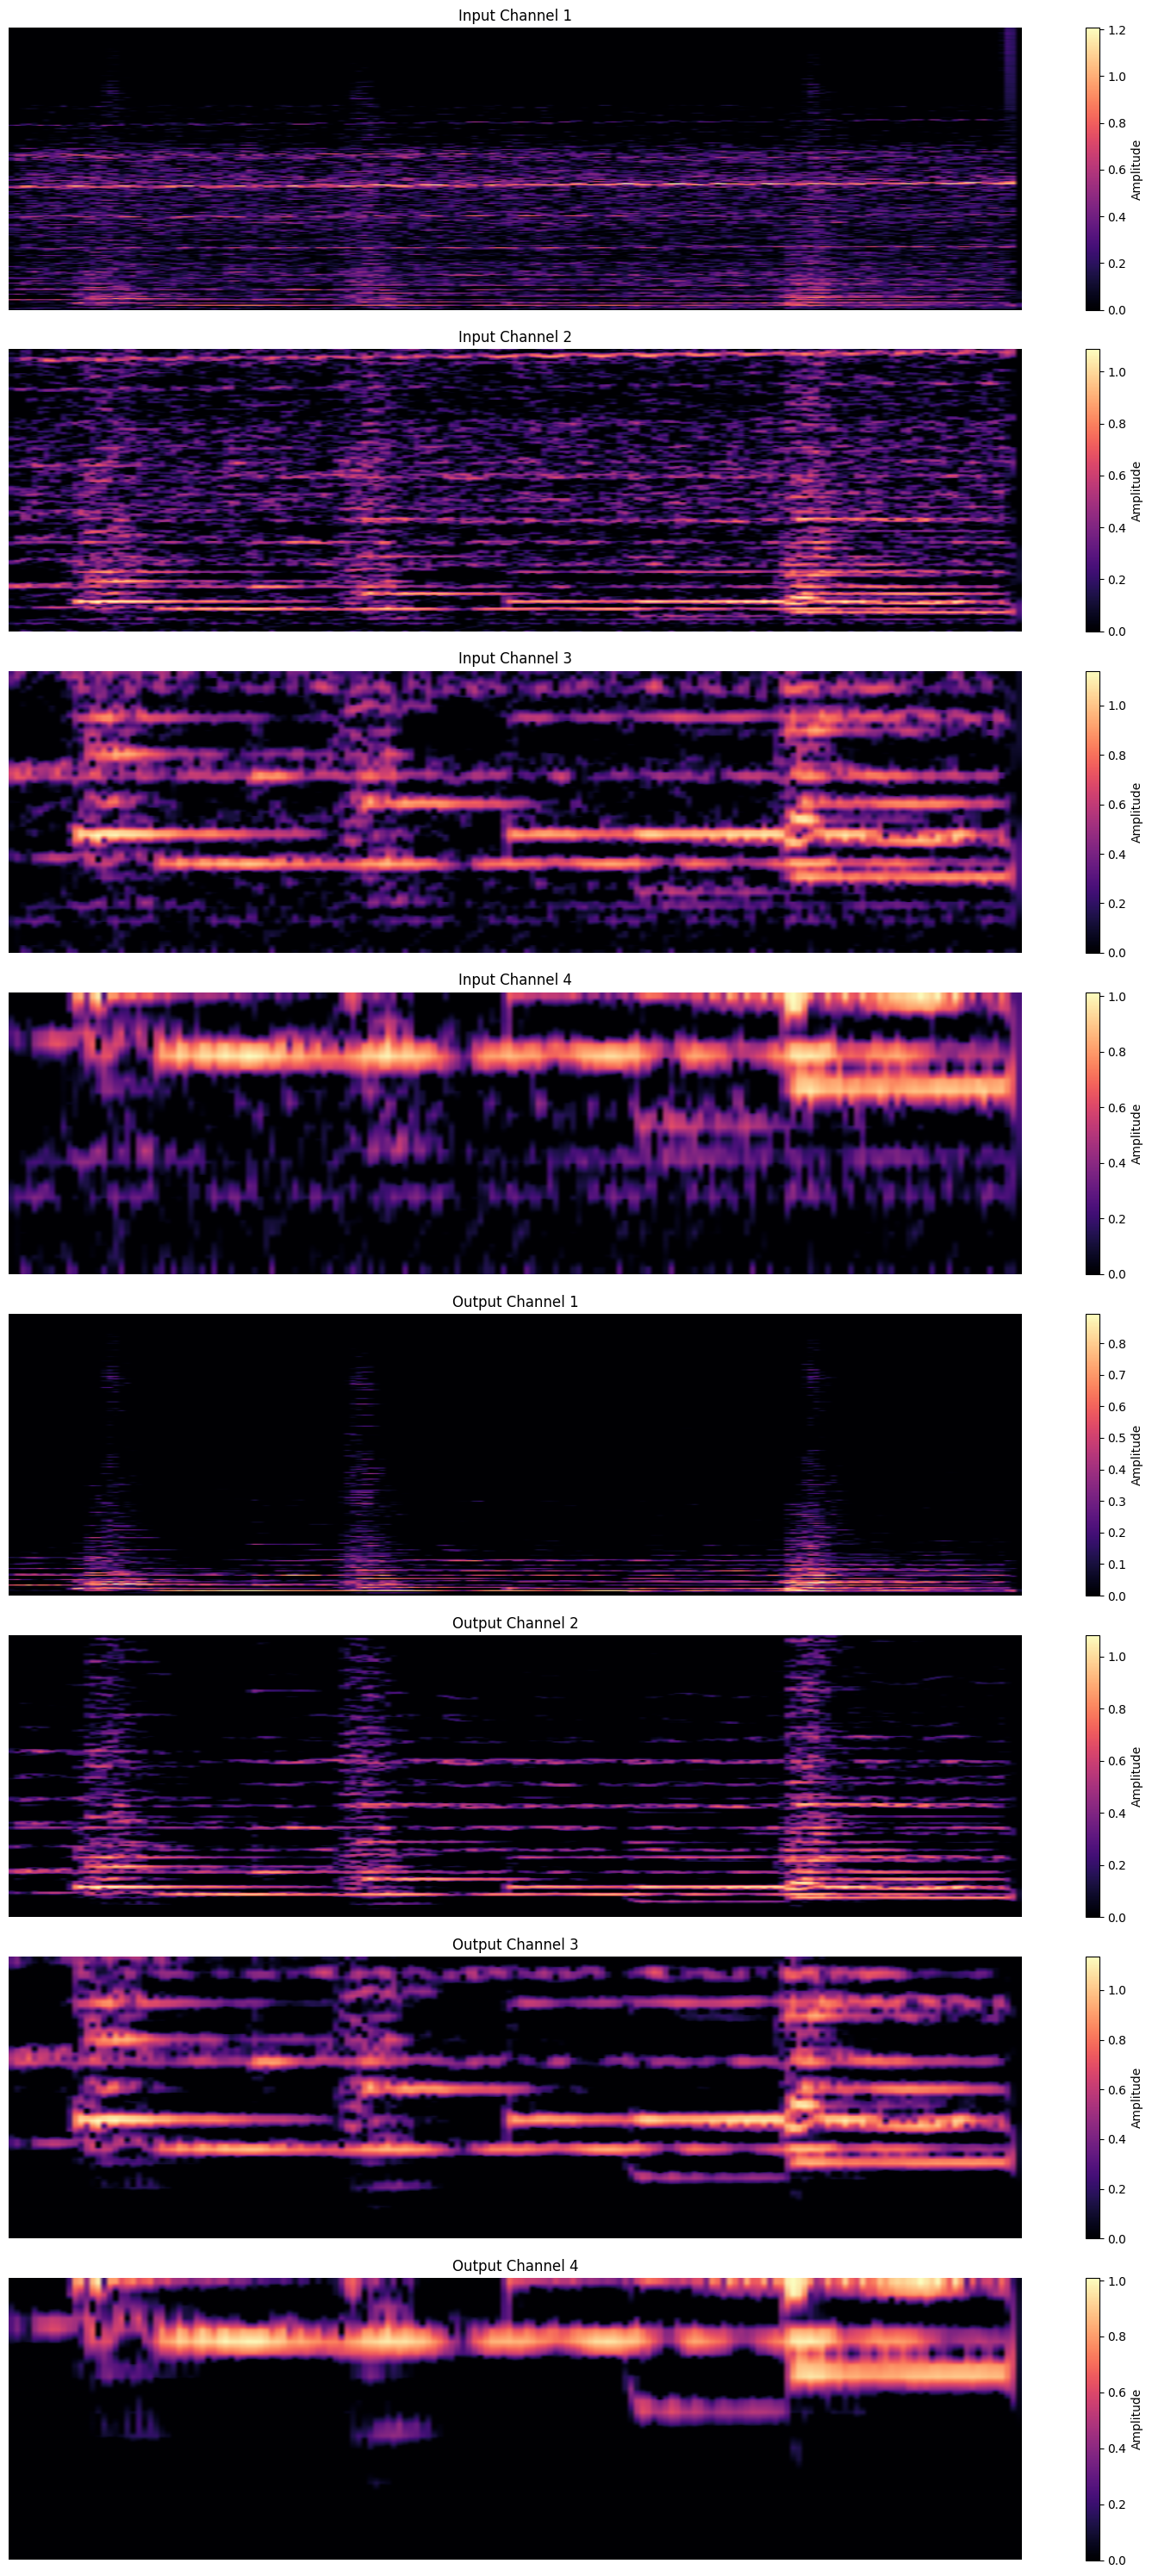

In [15]:
if LOAD_DATA:
  import matplotlib.pyplot as plt
  import torch
  import numpy as np
  import torch

  # Fetch a sample
  input_tensor, output_tensor, metadata = train_loader.train_dataset[51]

  print(metadata['snr_db'])

  # Convert to NumPy for plotting
  #input_array = np.clip(input_tensor.numpy(), -1, a_max=None)
  output_array = np.clip(output_tensor.numpy(), -1, a_max=None)
  input_array = np.clip(input_tensor.numpy(), -1, a_max=None)

  # remove negatve values
  #input_array = torch.clamp(input_array, min=0)  # Sets all negative values to 0
  print(np.shape(output_array))

  num_channels_out = output_array.shape[0]
  num_channels_in = input_array.shape[0]


  # Create subplots
  fig, axes = plt.subplots(num_channels_in + num_channels_out, 1, figsize=(15, 30))

  # Plot each input channel
  for i in range(num_channels_in):
      input = input_array[i]
      print(np.shape(input))
      print('Min, Max: ', np.min(input), np.max(input))
      im = axes[i].imshow(input, aspect='auto', cmap='magma')
      axes[i].invert_yaxis()

      axes[i].set_title(f"Input Channel {i+1}")
      axes[i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[i], orientation="vertical")
      cbar.set_label("Amplitude")

    # Plot each input channel
  for i in range(num_channels_out):
      output = output_array[i]
      print('Min, Max: ', np.min(output), np.max(output))
      im = axes[num_channels_in + i].imshow(output, aspect='auto', cmap='magma')
      axes[num_channels_in + i].invert_yaxis()

      axes[num_channels_in + i].set_title(f"Output Channel {i+1}")
      axes[num_channels_in + i].axis("off")

      # Add colorbar
      cbar = fig.colorbar(im, ax=axes[num_channels_in + i], orientation="vertical")
      cbar.set_label("Amplitude")

  plt.tight_layout()
  plt.show()


## Train Model

In [16]:
from audioautoencoder.loss import *
from audioautoencoder.utils import *

In [17]:
import torch

torch.cuda.empty_cache()

In [18]:
if load:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False
else:
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=eta_min)
  scheduler_loss = False

  #optimizer = None #torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
  #scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
  #scheduler_loss = False #True

In [19]:
from audioautoencoder.plotting import *
from audioautoencoder.training import *

In [20]:
import torch
import gc

def clear_gpu_memory():
    """Clears all allocated GPU memory in PyTorch."""
    torch.cuda.empty_cache()  # Clears cache
    gc.collect()  # Runs Python garbage collector
    for i in range(torch.cuda.device_count()):
        torch.cuda.reset_peak_memory_stats(i)  # Resets peak memory tracking

clear_gpu_memory()

In [21]:
from audioautoencoder.training import *

# plot example inputs



Training on device: cpu
Epoch 1, Current Learning Rate: [0.001]


Training:   0%|          | 0/1491 [00:00<?, ?batch/s]

New kl loss beta: 0.0
Noise Level:  0.1


Validating: 100%|██████████| 373/373 [01:30<00:00,  4.10batch/s, loss=joint loss: 0.2103]


--------------------------------------------------
Epoch 1, Validation Loss: 0.2103
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv10_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


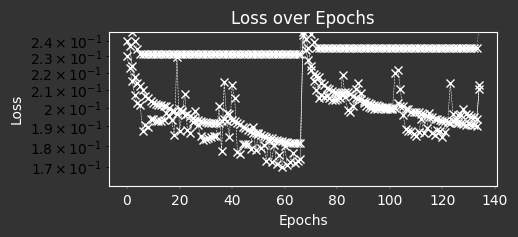

Epoch [1/100], Loss: 0.2129
--------------------------------------------------
Epoch 2, Current Learning Rate: [0.0009046039886902864]


Training:   0%|          | 0/1491 [00:00<?, ?batch/s]

New kl loss beta: 0.01
Noise Level:  0.08000000000000002


Validating: 100%|██████████| 373/373 [01:41<00:00,  3.66batch/s, loss=joint loss: 0.2042]


--------------------------------------------------
Epoch 2, Validation Loss: 0.2042
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv10_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


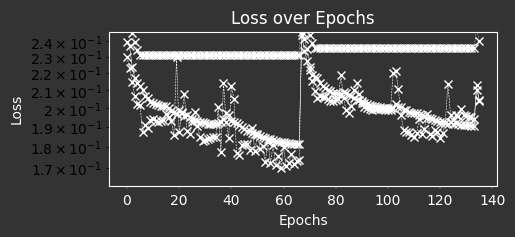

Epoch [2/100], Loss: 0.2045
--------------------------------------------------
Epoch 3, Current Learning Rate: [0.0006548539886902864]


Training:   0%|          | 0/1491 [00:00<?, ?batch/s]

New kl loss beta: 0.02
Noise Level:  0.06


Validating: 100%|██████████| 373/373 [01:26<00:00,  4.33batch/s, loss=joint loss: 0.1970]


--------------------------------------------------
Epoch 3, Validation Loss: 0.1970
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv10_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


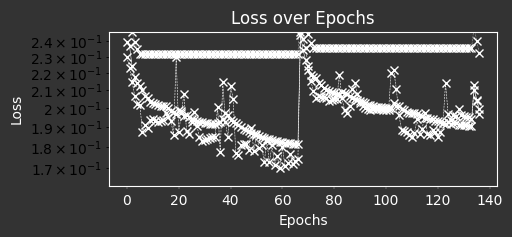

Epoch [3/100], Loss: 0.1997
--------------------------------------------------
Epoch 4, Current Learning Rate: [0.0003461460113097139]


Training:   0%|          | 0/1491 [00:00<?, ?batch/s]

New kl loss beta: 0.03
Noise Level:  0.04000000000000001


Validating: 100%|██████████| 373/373 [01:15<00:00,  4.94batch/s, loss=joint loss: 0.1946]


--------------------------------------------------
Epoch 4, Validation Loss: 0.1946
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv10_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


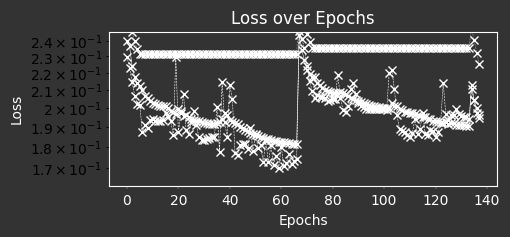

Epoch [4/100], Loss: 0.1959
--------------------------------------------------
Epoch 5, Current Learning Rate: [9.639601130971382e-05]


Training:   0%|          | 0/1491 [00:00<?, ?batch/s]

New kl loss beta: 0.04
Noise Level:  0.019999999999999997


Validating: 100%|██████████| 373/373 [01:17<00:00,  4.81batch/s, loss=joint loss: 0.1937]


--------------------------------------------------
Epoch 5, Validation Loss: 0.1937
Validation score improved. Saving model to /content/drive/MyDrive/Projects/ML_Projects/De-noising-autoencoder/Models_Comparison/Checkpoints_UNetConv10_-10-10/Autoencodermodel_earlystopping.pth.
Saved to Drive...


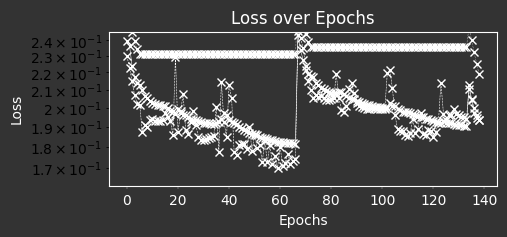

Epoch [5/100], Loss: 0.1934
--------------------------------------------------
Epoch 6, Current Learning Rate: [0.001]


Training:   0%|          | 0/1491 [00:00<?, ?batch/s]

New kl loss beta: 0.05
Noise Level:  0.0


Validating: 100%|██████████| 373/373 [01:35<00:00,  3.90batch/s, loss=joint loss: 0.1950]


--------------------------------------------------
Epoch 6, Validation Loss: 0.1950
EarlyStopping counter: 1 out of 100
Saved to Drive...


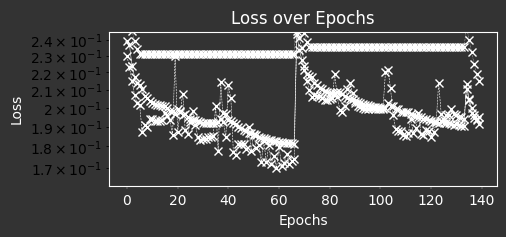

Epoch [6/100], Loss: 0.1913
--------------------------------------------------
Epoch 7, Current Learning Rate: [0.0009755527298894294]


Training:   0%|          | 0/1491 [00:00<?, ?batch/s]

New kl loss beta: 0.06
Noise Level:  0.0


Training:  81%|████████  | 1204/1491 [13:30<03:25,  1.40batch/s, loss=loss: 0.1894, ref:0.2138]

In [ ]:
if train:
  trainer = DenoisingTrainer(
      model=model, noisy_train_loader=train_loader.train_loader, noisy_val_loader=train_loader.val_loader,
      SNRdB=SNRdB, output_path=output_path, epochs=epochs, learning_rate=learning_rate,
      load=load, warm_start=warm_start, train=train, verbose=False, accumulation_steps=accumulation_steps, load_path=load_path,
      base_lr=base_lr, max_lr=max_lr, gamma=gamma, optimizer=optimizer, scheduler=scheduler, scheduler_loss=scheduler_loss,
      max_noise=0.1, noise_epochs=5, train_diffusion=train_diffusion
  )
  trainer.train_or_evaluate()
  model = trainer.get_model()

  # I need a flat load model function somewhere, as now I need to define a train loader before I can load a model
  csv_file_path = output_path + "training_log.csv"
  plot_training_log(csv_file_path)

___